# SI 330 FINAL PROJECT
## Modeling Major League Baseball Statistics against Varying Weather Conditions

**Name**: Andrew Ehrenberg

**Date**: 12/14/2018


In [1]:
#Import all necessary libraries 
import pandas as pd
import numpy as np
import requests
from forecastiopy import *
from collections import defaultdict
from datetime import datetime
import googlemaps
import urllib3.request
import requests_cache
import pickle
import json
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt 
import scipy
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from scipy.stats import ttest_ind
import warnings


# BASEBALL GAME LOGS
### **Source:** Retrosheet (via Data.World)
### **Type:** CSV File 
### **Size:** 83.8 MB, 92,000 rows X 160 columns
This data is a detailed stat sheet of every Major League Baseball game since around 1960. All of the stats are pulled from the game box score and broken into home and visitor columns. There is also contextual data about the game such as the day of the week, the park code, the time of day, etc. Together, this data will allow me to join weather data by transforming park codes into cities or lat/long points (cities, in the case of the weather API I used for this) to pass into a local historical weather query. 

In [2]:
#Turn off warnings (mostly for annoying deprecation stuff that doesn't impact functionality)
#Set some overarching preferences for pandas and seaborn
#Select the targeted selection from the massive baseball_logs DataFrame (games starting from 2000)
warnings.filterwarnings("ignore")
sns.set(font_scale = 2)
pd.options.display.max_columns = 500
pd.options.display.max_rows = 50
df = pd.read_csv("game_logs.csv")
df = df[38670:79968]

In [3]:
df.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional_walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,v_team_earned_runs,v_wild_pitches,v_balks,v_putouts,v_assists,v_errors,v_passed_balls,v_double_plays,v_triple_plays,h_at_bats,h_hits,h_doubles,h_triples,h_homeruns,h_rbi,h_sacrifice_hits,h_sacrifice_flies,h_hit_by_pitch,h_walks,h_intentional_walks,h_strikeouts,h_stolen_bases,h_caught_stealing,h_grounded_into_double,h_first_catcher_interference,h_left_on_base,h_pitchers_used,h_individual_earned_runs,h_team_earned_runs,h_wild_pitches,h_balks,h_putouts,h_assists,h_errors,h_passed_balls,h_double_plays,h_triple_plays,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_1_def_pos,v_player_2_id,v_player_2_name,v_player_2_def_pos,v_player_3_id,v_player_3_name,v_player_3_def_pos,v_player_4_id,v_player_4_name,v_player_4_def_pos,v_player_5_id,v_player_5_name,v_player_5_def_pos,v_player_6_id,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
38670,20000329,0,Wed,CHN,NL,1,NYN,NL,1,5,3,54,N,NaN,NaN,NaN,TOK01,55000.0,206.0,100010210,1000020,33.0,12.0,1.0,0.0,2.0,5.0,1.0,0.0,1.0,10.0,0.0,5.0,1.0,0.0,4.0,0.0,13.0,3.0,3.0,3.0,0.0,0.0,27.0,10.0,2.0,0.0,1.0,0.0,33.0,7.0,1.0,0.0,1.0,3.0,1.0,1.0,0.0,3.0,0.0,4.0,0.0,0.0,1.0,0.0,8.0,5.0,5.0,5.0,1.0,0.0,27.0,12.0,0.0,0.0,4.0,False,marsr901,Randy Marsh,herna901,Angel Hernandez,fostm901,Marty Foster,kulpr901,Ron Kulpa,NaN,(none),NaN,(none),bayld001,Don Baylor,valeb102,Bobby Valentine,liebj001,Jon Lieber,hampm001,Mike Hampton,aguir001,Rick Aguilera,andrs001,Shane Andrews,liebj001,Jon Lieber,hampm001,Mike Hampton,youne001,Eric Young,4.0,bufod001,Damon Buford,8.0,gracm001,Mark Grace,3.0,sosas001,Sammy Sosa,9.0,rodrh001,Henry Rodriguez,7.0,andrs001,Shane Andrews,5.0,nievj002,Jose Nieves,6.0,giraj001,Joe Girardi,2.0,liebj001,Jon Lieber,1.0,hendr001,Rickey Henderson,7.0,hamid001,Darryl Hamilton,8.0,alfoe001,Edgardo Alfonzo,4.0,piazm001,Mike Piazza,2.0,ventr001,Robin Ventura,5.0,belld001,Derek Bell,9.0,zeilt001,Todd Zeile,3.0,ordor001,Rey Ordonez,6.0,hampm001,Mike Hampton,1.0,NaN,Y
38671,20000330,0,Thu,NYN,NL,2,CHN,NL,2,5,1,66,N,NaN,NaN,NaN,TOK01,55000.0,235.0,1000004,1000000,37.0,6.0,2.0,0.0,1.0,5.0,1.0,1.0,1.0,8.0,0.0,5.0,1.0,0.0,0.0,0.0,10.0,5.0,0.0,0.0,0.0,0.0,33.0,14.0,2.0,0.0,2.0,0.0,36.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,1.0,9.0,0.0,0.0,2.0,0.0,10.0,7.0,5.0,5.0,0.0,0.0,33.0,14.0,0.0,0.0,0.0,False,herna901,Angel Hernandez,fostm901,Marty Foster,kulpr901,Ron Kulpa,marsr901,Randy Marsh,NaN,(none),NaN,(none),valeb102,Bobby Valentine,bayld001,Don Baylor,cookd00

### Mapping park IDs to cities

This baseball DataFrame gives us something which is close to a location - the park code. In order to make our data compatible with a weather API, we will need to at least derive the name of the corresponding city from each park code. At first, I thought I could perhaps do this through some sort of regular expression, but it ultimately was easier to just use the textFile that Retrosheet had provided with a dictionary of the park codes. I then created a new column in the DataFrame with the city names mapped onto the corresponding park IDs. 

In [4]:
park_ids = df.park_id.drop_duplicates() #Make a list of unique park codes

In [5]:
f = open("park_codes.txt", "r") #park_codes file (in the same directory) has cities attached to each park code, which is necessarily to later pass into the weather API 
park_dict = defaultdict(list)
for line in f.readlines()[1:]:
    fields = line.split(",")
    park_dict[fields[0]] = (fields[3]+", "+fields[4])
#park_dict

In [6]:
df['city']= df['park_id'].map(park_dict) #mapping city names into park ids

In [7]:
cache_fname = "cache.json" #Create and open a cache file
try:
    cacheFile = open(cache_fname, 'r')
    saved_cache = pickle.load(myCacheFile)
    cacheFile.close()
except:
    saved_cache = {}

# Function for requesting and caching weather data

In [10]:
#Function to request the weather API, while writing the request data to a cache file
#Takes city, start/end date (same date, in this case), in addition to the cache file and dictionary
def get_with_caching(city, start_date, end_date, cacheDict, cache_fname):
	myUrl = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=58c4342a8ae94160b2361248182711&q="\
    +city+"&format=json&date="+start_date+"&enddate="+end_date # I am keeping my personal key here for now, but all of the data is cached, so you likely won't need to use it.
	if myUrl in cacheDict:
		return cacheDict[myUrl]
	else:
		response = requests.get(myUrl)
		cacheDict[myUrl] = response.text
		myCacheFile = open(cache_fname, "wb")
		pickle.dump(cacheDict, myCacheFile)
		myCacheFile.close()
		return response.text

# Prepping the data for the weather request
 Here, I wrote a couple simple data transformation function to change raw dates to proper date times and index time-of-day to fit the format of the weather response

In [11]:
import datetime
def to_datetime(date):
    date = str(date)
    dt=datetime.datetime.strptime(date,'%Y%m%d')
    dt = dt.strftime('%Y-%m-%d')
    return dt

In [12]:
def to_hourly(dn):
    if dn == "D":
        return 4
    else:
        return 6

In [13]:
df["hr_code"] = df.day_night.apply(to_hourly)

In [14]:
df['date'] = df.date.transform(to_datetime)

## Construct a sample dataset within the bounds of my daily API usage limits
WorldWeatherOnline only allows me to access 500 weather endpoints each day (can sometimes push it to 750, but trying to be a good internet citizen), so I can only use a subset of my data to pass into the weather request. I have increased this number as my usage limits have reset each day order to expand my usable dataset. 

In [39]:
df_sample = df[::-1][:2750]
#df_sample

## Map cities onto dates
Each date is a unique key, whose values are a list of cities who held Major League Baseball games that day. 

In [40]:
#create an even smaller subFrame with only the data necessary to process the request (date, city name, and the time of day code) 
d = df_sample[["date", "city", "hr_code"]]
#create a dictionary with dates as keys and city names as values
#this dictionary represents all of the cities in which a game was played (values) on a given date (keys)
dt_city_dict = defaultdict(list)
for i in range(len(d)):
    dt_city_dict[(list(d.date)[i], list(d.hr_code)[i])].append(list(d.city)[i])


## Putting it all together: making API requests and getting data from the cache
Here, I make an iterative request that goes through every single date in the dictionary (I always make sure that the df_sample) is within around 500 entries of the data I already have cached, if I haven't already made additional requests that day). This is a nested for loop that iterates through each date key and then every city in the list mapped to that date. In the second for loop, I am then able to make a request for a specific date and city. As you can see, WorldWeatherOnline has a very usable interface - I don't even need to geocode my data (to lat/long) - I simply provide a city name, a start date and and end date as input and it returns a detailed hourly weather response. The hourly weather is broken into 3 hour blocks from 0 to 2100 (military time). With occasional exceptions, day games start around 12pm and  night games start around 6pm. This is why the hour codes are just a bunch of 4's and 6's - the 4th block is 1200 and the 6th block is 1800. 

## Why is the data put into a dictionary first rather than a DataFrame?
I chose to do this because I had to iterate through a dictionary in order to make one request at a time. Iteratively appending to a DataFrame cannot be done very well Pythonically, so I thought that working with Python data structures was more compatible with making a call to the requests library. By using a dictionary, I can easily iterate through cities and dates, creating a unique key for each (city, date) tuple, whose value is the portion weather API response pertaining to the time of day the game was played. This dictionary will then be iterated through to create a list of columns for the new DataFrame.  

In [20]:
weatherDict = {}
for key in dt_city_dict.keys():
    start = key[0]
    end = key[0]
    for city in dt_city_dict[key]:
        city = city
        q = get_with_caching(city, start, end, saved_cache, cache_fname)
        d = json.loads(q)
        #print(d)
        weatherDict[(city, start)] = d["data"]["weather"][0]["hourly"][key[1]] #key[1] represents the hr_code that indicates whether the game was a day or a night game


## Constructing columns for the new DataFrame
Instead of dealing with merging this with the original baseball DataFrame and having to deal with 160 columns of data during the analysis portion, I created a new DataFrame that will serve as the skeleton for the data pipeline, which can then be populated to best suit our needs

First, as mentioned above, I must iterate through all of the dictionary keys to add additional rows to each column. I accomplish this through several list comprehensions corresponding to each column of weather data. For the purposes of this analysis, I felt the most important weather indicators were temperature, precipitation, humidity, and wind (these seem to be the most common ways we qualitatively describe weather (i.e 'it's cold', 'it's humid', 'it's rainy', 'it's windy') - these qualitative factors tend to have some effect on our physical/mental well-being, so I was curious as to whether this factors have an effect on the performance of professional athletes who are exposed the elements. These list comprehensions form lists of data entries corresponding to a particular column. This can then be passed directly into the DataFrame - I just need to provide a column name. 

In [21]:
new_df = pd.DataFrame() #THIS DATAFRAME WILL BECOME THE PRINCIPAL DATAFRAME USED THROUGHOUT MOST OF THE PROJECT

In [41]:
dates = [key[1] for key in weatherDict.keys()]
cities = [key[0] for key in weatherDict.keys()]
description = [weatherDict[key]["weatherDesc"][0]["value"] for key in weatherDict.keys()]
temp = [float(weatherDict[key]["tempF"]) for key in weatherDict.keys()]
precip = [float(weatherDict[key]["precipMM"]) for key in weatherDict.keys()]
humidity = [float(weatherDict[key]["humidity"]) for key in weatherDict.keys()]
wind = [float(weatherDict[key]["WindGustMiles"]) for key in weatherDict.keys()]

new_df["date"] = dates
new_df["city"] = cities
new_df["description"] = description
new_df["temp"] = temp
new_df["precip"] = precip
new_df["humidity"] = humidity
new_df["wind"] = wind

length = len(new_df)
baseball_df = df_sample[:length]

## Data Categorization - classifying 'levels' of various weather output

In order to make powerful comparisons between varying weather conditions and MLB baseball games, segmenting certain weather variables into 'levels' makes it easier to classify a certain combination of weather conditions as 'good' or 'bad'. I approached this by constructing mini-functions with a single-purpose of classifying a single column of data (similar to the ones I used to transform the datetimes and classify the time of day).

Each function is slightly different based on the weather metric I am measuring, they each have similar components: construct intervals around the mean value somewhere between -3 and 3 standard deviations from the mean (representing the lowest and highest levels) and provide intermediate levels ((+/-) 1 to 2 standard deviations) as well. The mean may or may not be included as the middle level, depending on the nature of the weather data I was working with. For example, the temperature data had a cleaner distribution when I split it into cold, medium and hot as opposed to something like wind, where I looked at 5 different levels of output. 

These various levels are a great way to organize my analysis by looking at different classifications of weather variables in relation to baseball data. Instead of having to classify each time I want to examine a variable, I can do these calculations in the dataset before I visualize anything or run any statistical tests.

# TEMPERATURE

In [23]:
cold = new_df.temp.mean()-(3*new_df.temp.std())
cold_medium = new_df.temp.mean()-(new_df.temp.std())
medium_hot = new_df.temp.mean()+(new_df.temp.std())
def categorize_temp(temp):
    if temp > cold and temp < cold_medium:
        return "cold"
    elif temp > cold_medium and temp < medium_hot:
        return "medium"
    else:
        return "hot"
      

In [24]:
new_df["temp_level"] = new_df.temp.apply(categorize_temp)

# WIND

In [25]:
wind1 = new_df.wind.mean()-(3*new_df.wind.std())
wind2 = new_df.wind.mean()+(1.5 * new_df.wind.std())
wind3 = new_df.wind.mean()
wind4 = new_df.wind.mean()+(2 * new_df.wind.std())
wind5 = new_df.wind.mean()+(3 * new_df.wind.std())


def categorize_wind(wind):
    if wind > wind1 and wind < wind2:
        return 1
    elif wind > wind2 and wind < wind3:
        return 2
    elif wind > wind3 and wind < wind4:
        return 3
    elif wind > wind4 and wind < wind5:
        return 4
    else:
        return 5


In [26]:
new_df["wind_level"] = new_df.wind.apply(categorize_wind)

# HUMIDITY

In [27]:
humid1 = new_df.humidity.mean()-(3 * new_df.humidity.std())
humid2 = new_df.humidity.mean()-(1.5 * new_df.humidity.std())
humid3 = new_df.humidity.mean()
humid4 = new_df.humidity.mean()+(1.5 * new_df.humidity.std())
humid5 = new_df.humidity.mean()+(3 * new_df.humidity.std())

def categorize_humidity(humidity):
    if humidity > humid1 and humidity < humid2:
        return 1
    elif humidity > humid2 and humidity < humid3:
        return 2
    elif humidity > humid3 and humidity < humid4:
        return 3
    elif humidity > humid4 and humidity < humid5:
        return 4
    else:
        return 5


In [28]:
new_df["humidity_level"] = new_df.humidity.apply(categorize_humidity)

# PRECIPITATION

In [29]:
precip1 = new_df.precip.mean()-(1.5 * new_df.precip.std())
precip2 = new_df.precip.mean()
precip3 = new_df.precip.mean()+(1.5 * new_df.precip.std())
precip4 = new_df.precip.mean()+(3 * new_df.precip.std())

def categorize_precip(precip):
    if precip > precip1 and precip < precip2:
        return 1
    elif precip > precip2 and precip < precip3:
        return 2
    elif precip > precip3 and precip < precip4:
        return 3
    else:
        return 4


In [30]:
new_df["precip_level"] = new_df.precip.apply(categorize_precip)

## POPULATING AND ORGANIZING THE BASEBALL DATA
There is way to do this without dropping all the home and visitor columns at the end, but it was much easier to do a column-wise operation to derive the totals and then delete the home and visitor columns. For the purposes of this analysis, we don't really care about home vs. visiting team - we are more interested to see how the weather affected overall performance (which affects the statlines of both teams, which is why it is reasonable to focus on total stats rather than team or player-specific ones). 

This is a pretty manual process, but once done, this DataFrame is essentially completely ready for analysis!

In [54]:
new_df["home_score"] = list(baseball_df.h_score)
new_df["visitor_score"] = list(baseball_df.v_score)
new_df["total_score"] = new_df.home_score + new_df.visitor_score

new_df["home_hits"] = list(baseball_df.h_hits)
new_df["visitor_hits"] = list(baseball_df.v_hits)
new_df["total_hits"] = new_df.home_hits + new_df.visitor_hits

new_df["home_hrs"] = list(baseball_df.h_homeruns)
new_df["visitor_hrs"] = list(baseball_df.v_homeruns)
new_df["total_hrs"] = new_df.home_hrs + new_df.visitor_hrs

new_df["home_hbp"] = list(baseball_df.h_hit_by_pitch)
new_df["visitor_hbp"] = list(baseball_df.v_hit_by_pitch)
new_df["total_hbp"] = new_df.home_hbp + new_df.visitor_hbp

new_df["home_walks"] = list(baseball_df.h_walks)
new_df["visitor_walks"] = list(baseball_df.v_walks)
new_df["total_walks"] = new_df.home_walks + new_df.visitor_walks

new_df["home_strikeouts"] = list(baseball_df.h_strikeouts)
new_df["visitor_strikeouts"] = list(baseball_df.v_strikeouts)
new_df["total_strikeouts"] = new_df.home_strikeouts + new_df.visitor_strikeouts

new_df["home_sb"] = list(baseball_df.h_stolen_bases)
new_df["visitor_sb"] = list(baseball_df.v_stolen_bases)
new_df["total_sb"] = new_df.home_sb + new_df.visitor_sb

new_df["home_wp"] = list(baseball_df.h_wild_pitches)
new_df["visitor_wp"] = list(baseball_df.v_wild_pitches)
new_df["total_wp"] = new_df.home_wp + new_df.visitor_wp

new_df["home_errors"] = list(baseball_df.h_errors)
new_df["visitor_errors"] = list(baseball_df.v_errors)
new_df["total_errors"] = new_df.home_errors + new_df.visitor_errors

new_df = new_df.drop(columns = ["home_score", "visitor_score", "home_hits", "visitor_hits", "home_hrs", \
                               "visitor_hrs", "home_hbp", "visitor_hbp", "home_sb", "visitor_sb", "home_wp", \
                               "visitor_wp", "home_errors", "visitor_errors", "home_strikeouts", "visitor_strikeouts", \
                               "home_walks", "visitor_walks"])


In [55]:
len(new_df)

2707

In [57]:
#Import viz libraries and indicate specific settings preferences
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams["figure.figsize"] = (20,10)
from matplotlib.pyplot import figure

### Classification in Action: Good vs. Bad Weather
Create subframes of good and bad weather based on 3 weather variables - temperature, wind, and precipitation. 'Medium' temperatures and wind/precip values under 3 are considered 'good' weather (moderate temperature, not windy, not rainy) and everything else is considered bad weather. By examining 3 weather variables at once, hopefully I can isolate some of the key baseball stats differences in different weather conditions. Once the subframes are created, we can iterate through the different statistical columns (by filtering on 'total') and find the mean value of the rows in each column.

In [52]:
good_weather = new_df[(new_df.temp_level == "medium") & (new_df.wind_level < 3) & (new_df.precip_level < 3)]
bad_weather = new_df[(new_df.temp_level != "medium") & (new_df.wind_level >= 3) & (new_df.precip_level >= 3)]
good_weather_means = [(col, good_weather[col].mean()) for col in good_weather.columns if "total" in col]
bad_weather_means = [(col, bad_weather[col].mean()) for col in bad_weather.columns if "total" in col]

After creating a list of tuples containing the column and its mean, we can create a bar chart that plots the means of each column for both good and bad weather. This is a grouped bar chart, so we are able to see what the good_weather means look like next to the bad_weather ones.

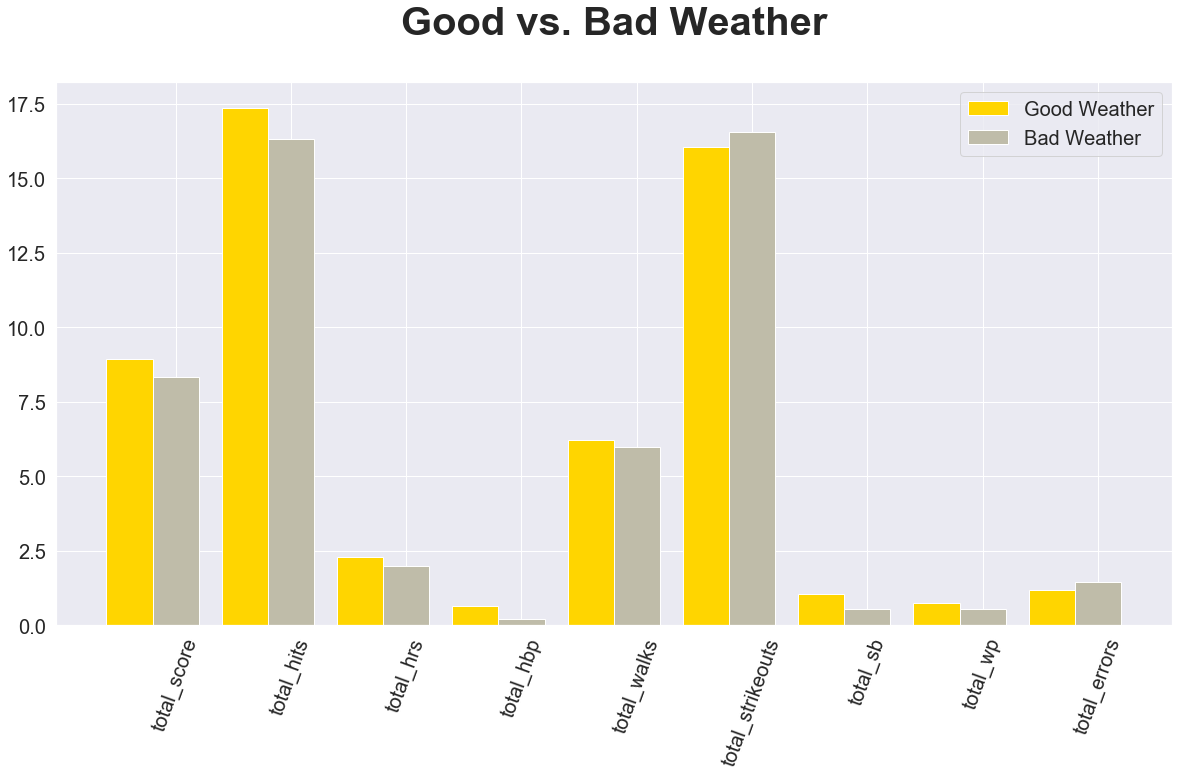

In [58]:
barWidth = 0.4
good_weather_bars = [mean[1] for mean in good_weather_means]
bad_weather_bars = [mean[1] for mean in bad_weather_means]

r1 = np.arange(len(good_weather_bars))
r2 = [x + barWidth for x in r1]

plt.bar(r1, good_weather_bars, color='#FFD500', width=barWidth, edgecolor='white', label='Good Weather')
plt.bar(r2, bad_weather_bars, color='#BFBCA9', width=barWidth, edgecolor='white', label='Bad Weather')

plt.title('Good vs. Bad Weather\n', fontweight='bold', fontsize = 40)
plt.xticks([r + barWidth for r in range(len(good_weather_bars))],[val[0] for val in good_weather_means])
plt.xticks(rotation=70)

plt.legend(fontsize=20)
plt.show()

**Analysis:** There are some noticable differences in some of the mean values between good and bad weather games. Good weather games have about a +1 edge in both total score and total hits. This makes some intuitive sense, as offenses should benefit from better weather (but defenses do as well!) There are also noticably more stolen bases in good weather games. Bad weather games have slightly more errors and strikeouts. To understand statistical significance among this data, I must run some t-tests

In [65]:
ttest_ind(good_weather.total_hits, bad_weather.total_hits)

Ttest_indResult(statistic=0.5957287932087955, pvalue=0.5514377291374837)

In [69]:
ttest_ind(good_weather.total_score, bad_weather.total_score)

Ttest_indResult(statistic=0.41392974343755207, pvalue=0.6789790982235673)

As you can see from these t-tests, although there are some noticable differences in the data when you look at the averages, this tells us that the deviation is not significant enough to suggests a 'significant difference' in means. This makes sense given that the differences between the two datasets aren't that stark, but I would have expected something slightly more compelling here. 

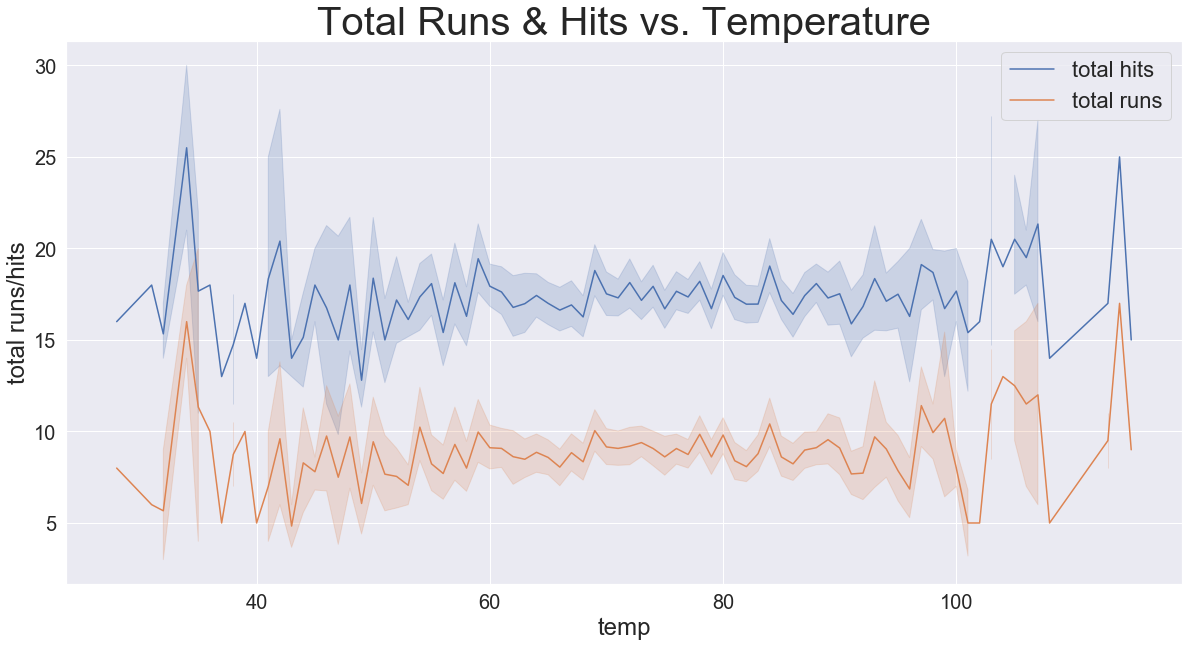

In [71]:
plt.figure("Temp Plots (Hits, Runs)")
sns.lineplot(new_df.temp, new_df.total_hits,label = "total hits").set_title("Total Runs & Hits vs. Temperature", fontsize = 40)
sns.lineplot(new_df.temp, new_df.total_score, label = "total runs")
plt.ylabel("total runs/hits")
plt.legend()
plt.show()
#CALCULATE VARIANCE AT LOW AND HIGH TEMPS

This models total score and total hits against temperature. There is a visual story here - When the temperature is below 50, both runs and hits experience severe volatility. As temperatures become more moderate, the data flattens out, but becomes volatile again when temperature rises above 90. This can be explained by hitters feeling more comfortable in temperate conditions. 

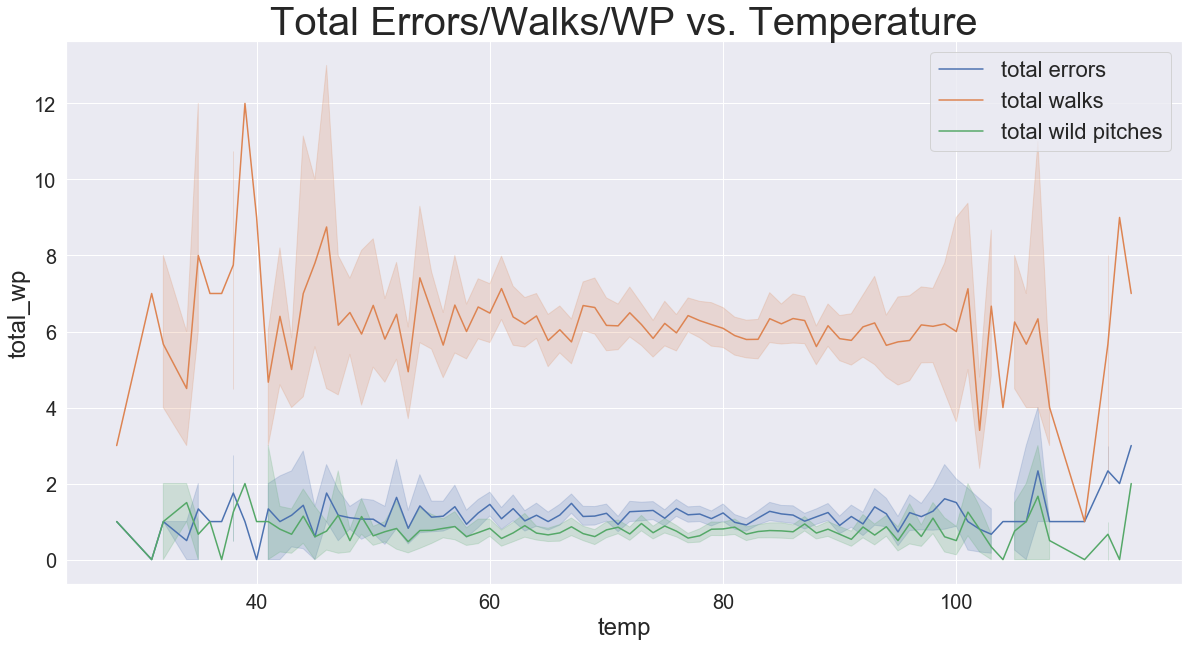

In [97]:
plt.figure("Temp Plots (Errors, Walks, Wild Pitches)")
sns.lineplot(new_df.temp, new_df.total_errors,label = "total errors").set_title("Total Errors/Walks/WP vs. Temperature", fontsize = 40)
sns.lineplot(new_df.temp, new_df.total_walks, label = "total walks")
sns.lineplot(new_df.temp, new_df.total_wp, label = "total wild pitches")
plt.legend()
plt.show()

The same goes for this chart, which instead models the pitching-specific data. The data exhibits pretty similar behavior to the scoring/hitting data. There are similar patterns of instability at lower temperatures and higher temperatures with relative stability in the middle. While much of this instability could be explained by increased comfort in moderate weathher, this may also have to do with the fact there there are less games played at extreme temperatures, which make variations in the data more noticable. 

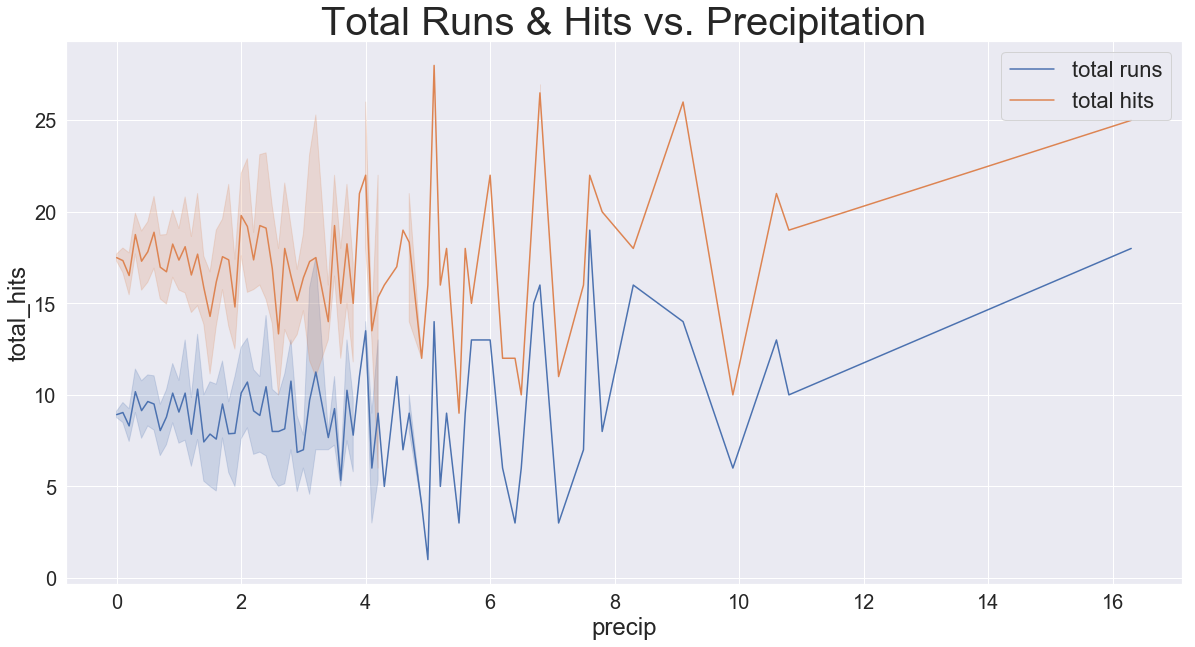

In [472]:
sns.lineplot(new_df.precip, new_df.total_score, label = "total runs").set_title("Total Runs & Hits vs. Precipitation", fontsize = 40)
sns.lineplot(new_df.precip, new_df.total_hits, label = "total hits")

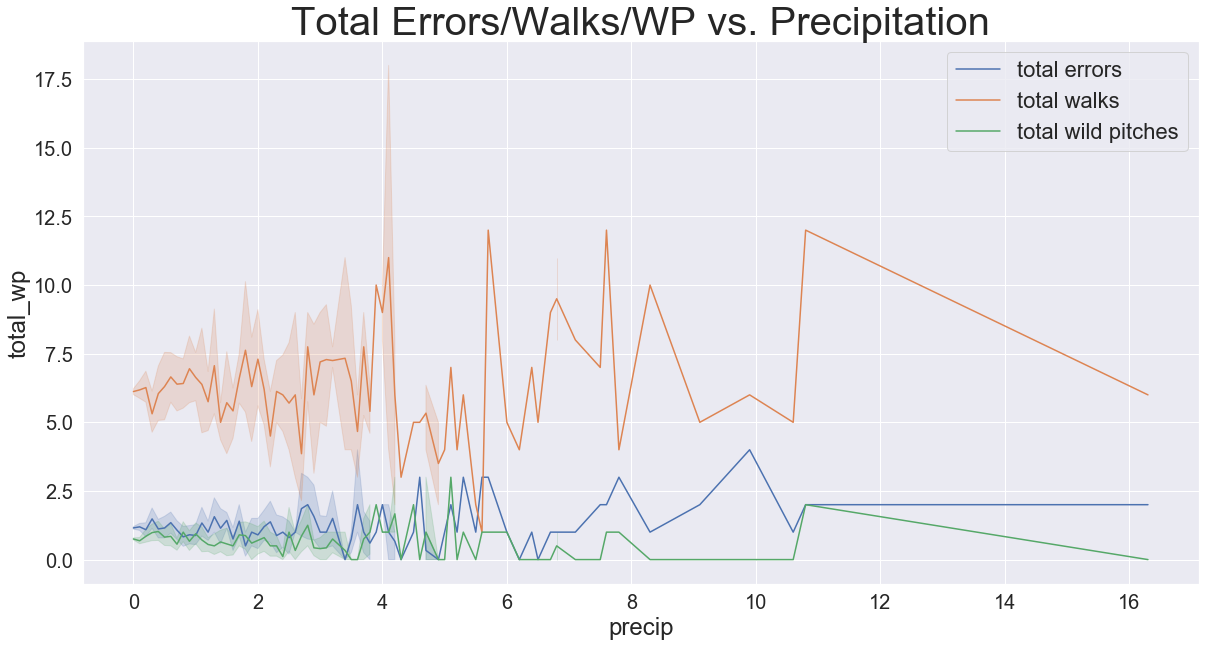

In [473]:
sns.lineplot(new_df.precip, new_df.total_errors, label = "total errors").set_title("Total Errors/Walks/WP vs. Precipitation", fontsize = 40)
sns.lineplot(new_df.precip, new_df.total_walks, label = "total walks")
sns.lineplot(new_df.precip, new_df.total_wp, label = "total wild pitches")

Here, I modeled the same baseball statistics against precipitation data and found a similar trend - extreme/inclement weather conditions (in this case, higher precipitation) have wider levels of variation than more moderate conditions. As precipitation level increases, the range of potential outcomes becomes a lot broader.

## Assessing statistical significance and temperature
Here, I ran Tukeys MultiComparisons for each statistical variable I looked at (score, hits, walks, errors, wild pitches) to do a comparison on statistical significance amongst these variables in different temperature classifications. The only significant difference I found was for walks in cold vs. hot games - there are significantly more walks during cold games

In [60]:
pairwise_tukeyhsd(new_df.total_score, new_df.temp_level).summary()

group1,group2,meandiff,lower,upper,reject
cold,hot,0.5355,-0.1947,1.2656,False
cold,medium,0.3563,-0.2165,0.9291,False
hot,medium,-0.1792,-0.7469,0.3885,False


In [61]:
pairwise_tukeyhsd(new_df.total_hits, new_df.temp_level).summary()

group1,group2,meandiff,lower,upper,reject
cold,hot,0.4421,-0.4012,1.2853,False
cold,medium,0.2448,-0.4167,0.9063,False
hot,medium,-0.1973,-0.8529,0.4583,False


In [62]:
pairwise_tukeyhsd(new_df.total_walks, new_df.temp_level).summary()

group1,group2,meandiff,lower,upper,reject
cold,hot,-0.4908,-0.9581,-0.0235,True
cold,medium,-0.2456,-0.6122,0.121,False
hot,medium,0.2452,-0.1181,0.6085,False


In [63]:
pairwise_tukeyhsd(new_df.total_errors, new_df.temp_level).summary()

group1,group2,meandiff,lower,upper,reject
cold,hot,0.0201,-0.1688,0.2089,False
cold,medium,-0.003,-0.1511,0.1452,False
hot,medium,-0.023,-0.1699,0.1238,False


In [211]:
pairwise_tukeyhsd(new_df.total_wp, new_df.temp_level).summary()

group1,group2,meandiff,lower,upper,reject
cold,hot,-0.0005,-0.1392,0.1382,False
cold,medium,-0.0011,-0.1094,0.1071,False
hot,medium,-0.0006,-0.1083,0.107,False


## PLOT BY JUST TEMPERATURE
In this example, instead of combining multiple weather variables to assess 'good' vs. 'bad', I am just using the temperature classification to look at average statistics when it is cold/medium/hot. There aren't very powerful differences here, but you can see some differences that such as more pure offensive output (runs, hits, HRs) in warmer games and more walks in colder games.   

In [77]:
cold = new_df[new_df.temp_level == "cold"]
medium = new_df[new_df.temp_level == "medium"]
hot = new_df[new_df.temp_level == "hot"]

In [78]:
cold_means = [(col, cold[col].mean()) for col in cold.columns if "total" in col]
medium_means = [(col, medium[col].mean()) for col in medium.columns if "total" in col]
hot_means = [(col, hot[col].mean()) for col in hot.columns if "total" in col]

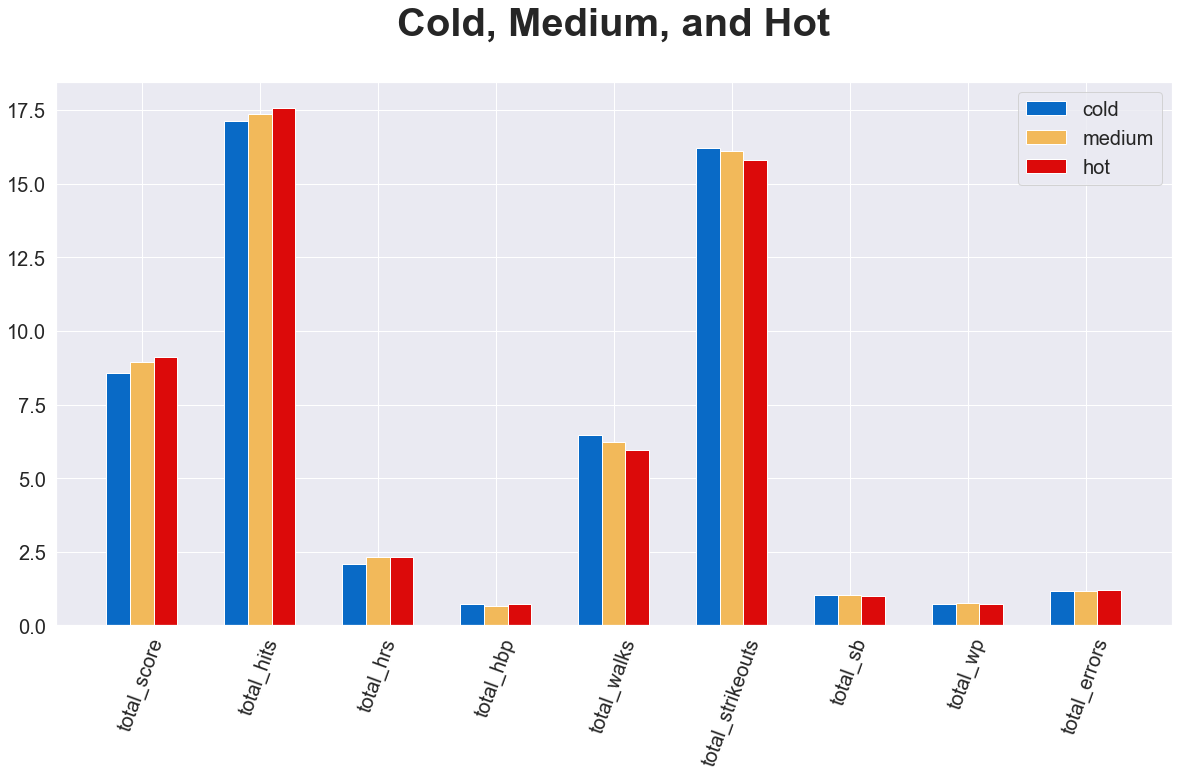

In [80]:
barWidth = 0.2
cold_bars = [mean[1] for mean in cold_means]
medium_bars = [mean[1] for mean in medium_means]
hot_bars = [mean[1] for mean in hot_means]

r1 = np.arange(len(cold_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, cold_bars, color = '#096AC6', width=barWidth, edgecolor='white', label='cold')
plt.bar(r2, medium_bars, color = '#F2B95A', width=barWidth, edgecolor='white', label='medium')
plt.bar(r3, hot_bars, color = '#DC0A0A', width=barWidth, edgecolor='white', label='hot')

plt.title('Cold, Medium, and Hot\n', fontweight='bold', fontsize = 40)
plt.xticks([r + barWidth for r in range(len(cold_bars))],[val[0] for val in cold_means])
plt.xticks(rotation=70)

plt.legend(fontsize=20)
plt.show()

#WHO DOES BETTER IN COLD VS. WHO DOES BETTER IN HOT? OFFENSE/DEFENSE

## DIFFERENCES IN VARIANCES OF BASEBALL STATS AT DIFFERENT TEMPERATURES
I created a small dataframe with differences in variance given different stats and temperature classifications. This gives me a sense of the volatility of each datapoint in relation to the weather. Some of the more volatile columns are total_score in hot vs. cold weather (1.52), total_strikeouts in hot vs. medium weather (-1.47), and total_hits in medium vs. cold weather (-1.02)

In [81]:
cold_vars = cold.var()[4:]
med_vars = medium.var()[4:]
hot_vars = hot.var()[4:]
varDict = {}
index = list(cold_vars.to_frame().reset_index()["index"])
for i in range(len(cold_vars)):
    varDict[index[i]] = {}
    varDict[index[i]]["MEDIUM-COLD"] = med_vars[i]-cold_vars[i]
    varDict[index[i]]["HOT-MEDIUM"] = hot_vars[i]-med_vars[i]
    varDict[index[i]]["HOT-COLD"] = hot_vars[i]-cold_vars[i]
    

In [82]:
var_df = pd.DataFrame.from_dict(varDict)
var_df

,wind_level,humidity_level,precip_level,total_score,total_hits,total_hrs,total_hbp,total_walks,total_strikeouts,total_sb,total_wp,total_errors
HOT-COLD,-0.814770,0.02448,-0.140497,0.769272,-2.230253,0.319548,-0.031352,-0.622090,-0.096773,-0.039916,-0.063826,-0.067205
HOT-MEDIUM,-0.128479,0.05414,-0.179334,-0.049753,-3.384384,0.174741,0.110503,0.122439,-0.797775,-0.037420,-0.231180,-0.000752
MEDIUM-COLD,-0.686291,-0.02966,0.038837,0.819024,1.154130,0.144806,-0.141856,-0.744528,0.701002,-0.002496,0.167354,-0.066452


## ASSESSING CORRELATIONS BETWEEN BASEBALL AND WEATHER VARIABLES 
Although there are no particularly strong correlations, the matrix and bar graph below give us an interesting sense of which relationships are strongest (on a relative scale). These correlations (albeit weak) tend to make logical sense within the context of the game. For instance, the strongest positive correlations are for total home runs for temperature and precipitation. From a temperature standpoint, this makes logical sense, as hitters are looser in warmer conditions. For precipitation, the argument is a bit more far-fetched, but perhaps pitchers miss their spots more in the rain, causing hitters to take advantage of more poorly executed pitches. In terms of negative correlations, the strongest is for temperature and walks - earlier, we determined that there was a significant difference for walks in cold games vs. hot games, so this correlation is communicating that this relationship is indeed negative and that lower temperatures lead to more walks.

In [96]:
corr = new_df.corr().reset_index()
corr = corr[7:][["index", "temp", "precip", "humidity", "wind"]]
index = list(corr["index"])
temp = list(corr.temp)
precip = list(corr.precip)
humidity = list(corr.humidity)
wind = list(corr.wind)

barWidth = 0.2
r1 = np.arange(len(index))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

corr

,index,temp,precip,humidity,wind
7,total_score,0.040971,0.023196,-0.009128,-0.011350
8,total_hits,0.037068,0.005945,-0.032741,-0.018908
9,total_hrs,0.057293,0.054690,-0.019063,-0.025026
10,total_hbp,0.016134,-0.022790,-0.016045,-0.028746
11,total_walks,-0.037622,0.036942,0.034911,0.022107
12,total_strikeouts,-0.012018,0.008018,0.014473,0.010720
13,total_sb,-0.000647,-0.016269,0.020045,0.004209
14,total_wp,-0.008128,-0.022397,-0.002682,0.005493
15,total_errors,0.015577,0.005438,0.000524,-0.002050


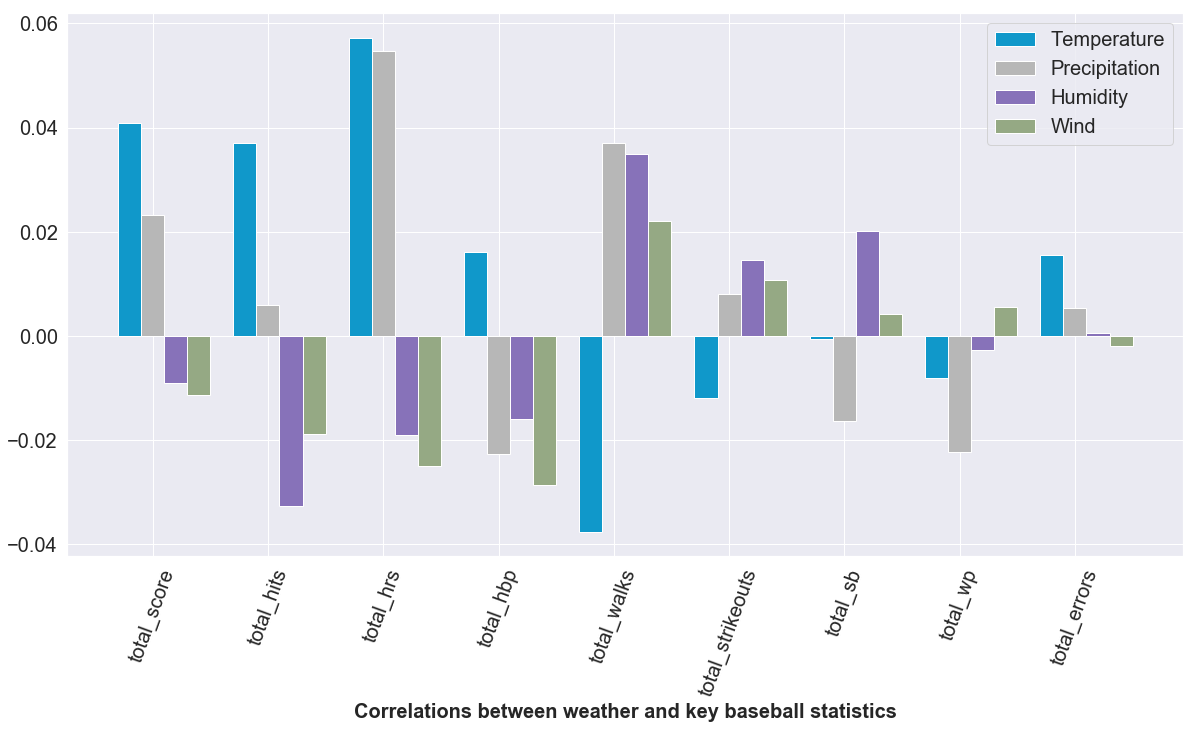

In [97]:
plt.bar(r1, temp, color = '#1098CA', width=barWidth, edgecolor='white', label='Temperature')
plt.bar(r2, precip, color = '#B7B7B7', width=barWidth, edgecolor='white', label='Precipitation')
plt.bar(r3, humidity, color = '#8772B9', width=barWidth, edgecolor='white', label='Humidity')
plt.bar(r4, wind, color = '#95A984', width=barWidth, edgecolor='white', label='Wind')

plt.xlabel('Correlations between weather and key baseball statistics', fontweight='bold', fontsize = 20)
plt.xticks([r + barWidth for r in range(len(cold_bars))],[val for val in index])
plt.xticks(rotation=70)

plt.legend(fontsize=20)
plt.show()

## PAIRPLOT OF LINEAR RELATIONSHIPS BETWEEN WEATHER DATA AND BASEBALL STATISTICS
This is another way of looking at correlation, but gives us more of a graphical representation of what the data actually looks like. As you can see, there aren't any overwhelmingly clear relationships (hence the low correlation coefficients in the table and chart above), but in the ones with stronger correlations, you can definitely see some sort pattern in the direction the coefficient indicates. 

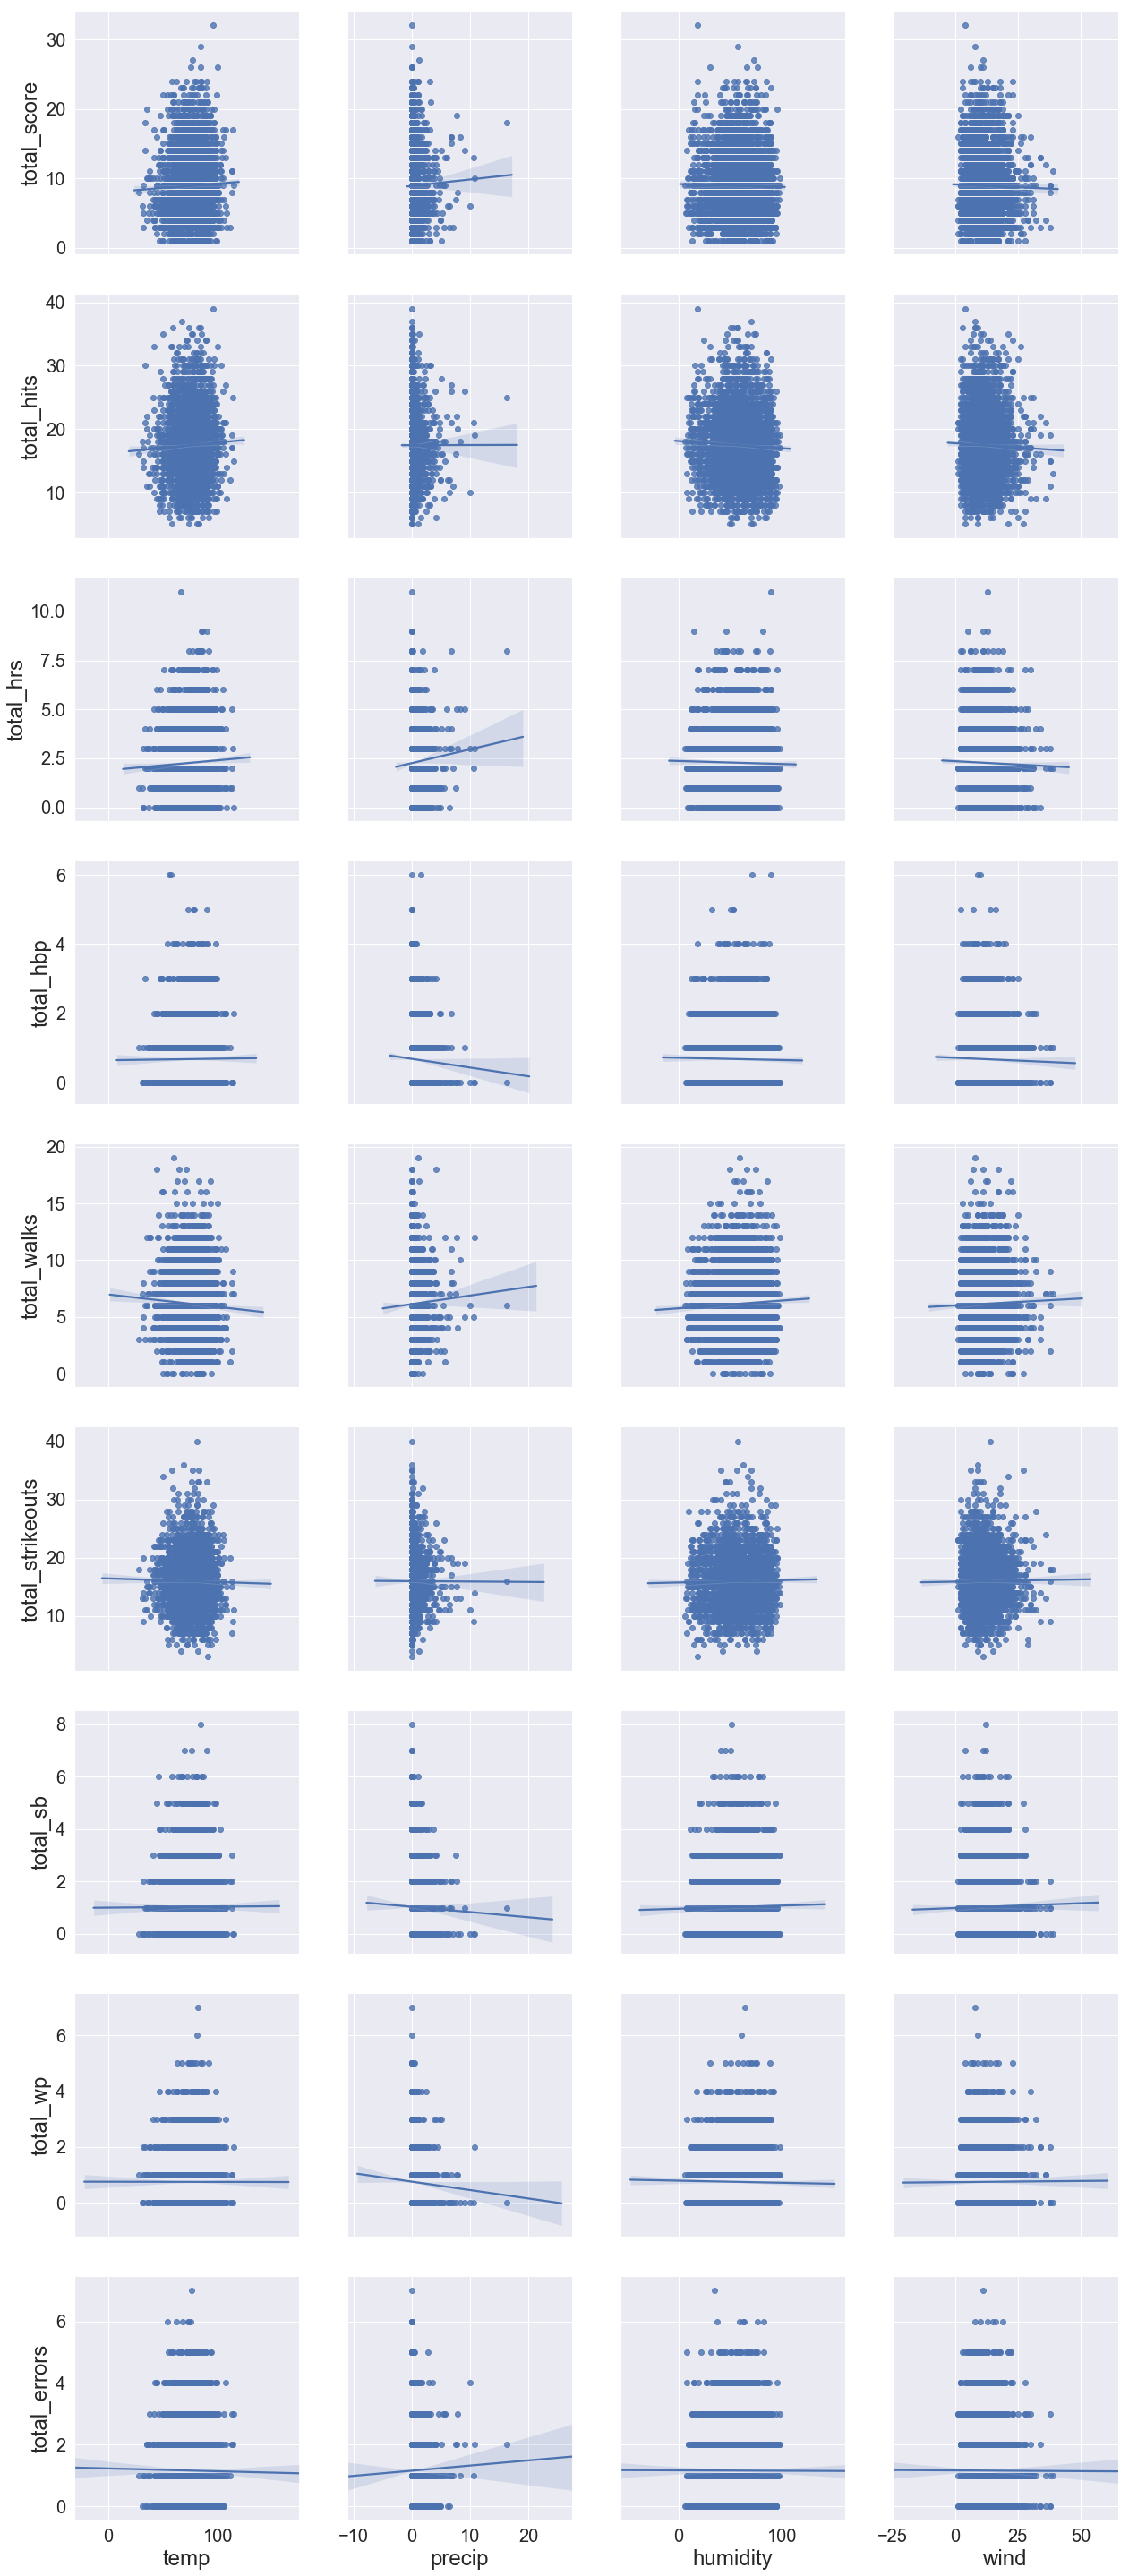

In [485]:
sns.pairplot(new_df, x_vars=["temp", "precip", "humidity", "wind"], y_vars= ["total_score", "total_hits", "total_hrs", "total_hbp", 
                                                                                           "total_walks", "total_strikeouts", "total_sb", "total_wp", "total_errors"], kind = "reg", height = 4.5)